In [1]:
from __future__ import print_function, division
from keras.constraints import max_norm
from keras.regularizers import l2
from custom_layers import Conv1D_linearphase
from heartnet_v1 import heartnet, reshape_folds, branch
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard, Callback
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Concatenate, initializers, Input
from keras.models import Model
from keras import backend as K
from sklearn.metrics import recall_score, confusion_matrix
import pandas as pd
import os
import tables
from datetime import datetime
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK

Using TensorFlow backend.


In [2]:
def compute_weight(Y, classes):
    num_samples = (len(Y))
    n_classes = (len(classes))
    num_bin = np.sum(Y,axis=-2)
    class_weights = {i: (num_samples / (n_classes * num_bin[i])) for i in range(n_classes)}
    return class_weights

In [3]:
def heartnet_transfer(load_path='/home/prio/heart_sound/weights.0148-0.8902.hdf5',
                      lr=0.0012843784,lr_decay=0.0001132885,
                      num_dense1=20,num_dense2=20,trainable=False,dropout_rate=0.):
    model = heartnet(load_path=False,FIR_train=False,trainable=trainable)
    plot_model(model,'before.png',show_shapes=True,show_layer_names=True)
    x = model.layers[-4].output
    x = Dense(num_dense1,activation='relu',kernel_initializer=initializers.he_uniform(seed=1)) (x)
    x = Dropout(rate=dropout_rate,seed=1) (x)
    x = Dense(num_dense2, activation='relu',kernel_initializer=initializers.he_normal(seed=1))(x)
    x = Dropout(rate=dropout_rate, seed=1)(x)
    output = Dense(3,activation='softmax')(x)
    model = Model(inputs=model.input,outputs=output)
    plot_model(model, 'after.png',show_shapes=True,show_layer_names=True)
    if load_path:
        model.load_weights(load_path,by_name=True)
    sgd = Adam(lr=lr)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
class log_UAR(Callback):

    def __init__(self, x_val, y_val, val_parts):
        self.x_val = x_val
        self.y_val = y_val
        self.val_parts = val_parts


    def on_epoch_end(self, epoch, logs):
        if logs is not None:
            y_pred = self.model.predict(self.x_val, verbose=0)
            y_pred = np.argmax(y_pred, axis=-1)
            self.y_val_ = np.transpose(np.argmax(self.y_val, axis=-1))
            true = []
            pred = []
            start_idx = 0
            for s in self.val_parts:

                if not s:  ## for e00032 in validation0 there was no cardiac cycle
                    continue
                # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)

                temp_ = self.y_val_[start_idx:start_idx + int(s) - 1]
                temp = y_pred[start_idx:start_idx + int(s) - 1]

                if (sum(temp == 0) > sum(temp == 1)) and (sum(temp == 0) > sum(temp == 2)):
                    pred.append(0)
                elif (sum(temp == 2) > sum(temp == 1)) and (sum(temp == 2) > sum(temp == 0)):
                    pred.append(2)
                else:
                    pred.append(1)

                if (sum(temp_ == 0) > sum(temp_ == 1)) and (sum(temp_ == 0) > sum(temp_ == 2)):
                    true.append(0)
                elif (sum(temp_ == 2) > sum(temp_ == 1)) and (sum(temp_ == 2) > sum(temp_ == 0)):
                    true.append(2)
                else:
                    true.append(1)

                start_idx = start_idx + int(s)

#             score = recall_score(y_pred=pred, y_true=true, average='macro')
            confmat = confusion_matrix(y_pred=pred, y_true=true)
            logs['recall0'] = confmat[0,0]/np.sum(confmat[0,:])
            logs['recall1'] = confmat[1,1]/np.sum(confmat[1,:])
            logs['recall2'] = confmat[2,2]/np.sum(confmat[2,:])
            logs['UAR'] = np.mean([logs['recall0'],logs['recall1'],logs['recall2']])

In [5]:
fold_dir = '/home/prio/heart_sound/feature/segmented_noFIR/'
foldname = 'comParE'
model_dir = '/home/prio/heart_sound/models/'
log_dir = '/home/prio/heart_sound/logs/'

##### Load Model ######
load_path='/home/prio/heart_sound/weights.0148-0.8902.hdf5'
# lr = 0.00001
# lr = 0.006028585143146318
num_dense1 = 1458 #34,120,167,239,1239,650,788,422,598
num_dense2 = 179 #121,
epochs = 45
batch_size = 256
dropout_rate = 0.11366
trainable = False
addweights = True

In [6]:
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]
############### Reshaping ############
x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)

(17061, 2500, 1)
(17061, 1)
(5872, 2500, 1)
(5872, 1)


In [7]:
def objective(args):
    #### Parse arguments and print #####
    
    print("args %s" % args)
    
    lr = args['lr']
#     num_dense1 = args['num_dense1']
#     num_dense2 = args['num_dense2']
#     dropout_rate = args['dropout_rate']
    
    ##### Load model ######
    model = heartnet_transfer(load_path=load_path,lr=lr,num_dense1=num_dense1,
                              num_dense2=num_dense2,trainable=trainable,
                              dropout_rate=dropout_rate)
    
    #### Log params #####
    log_name = foldname + ' ' + str(datetime.now()) + str(args.values())
    checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
    if not os.path.exists(model_dir + log_name):
        os.makedirs(model_dir + log_name)
    plot_model(model,"model.png",show_layer_names=True,show_shapes=True)
    
    ### Callbacks ###
    
    csv_logger = CSVLogger(log_dir + log_name + '/training.csv')
    modelcheckpnt = ModelCheckpoint(filepath=checkpoint_name,
                                    monitor='val_acc', save_best_only=False, mode='max')
    tensbd = TensorBoard(log_dir=log_dir + log_name,
                         batch_size=batch_size,
                         # histogram_freq=100,
                         # embeddings_freq=99,
                         # embeddings_layer_names=embedding_layer_names,
                         # embeddings_data=x_val,
                         # embeddings_metadata=metadata_file,
                         write_images=False)
    class_weights=compute_weight(y_train,range(3))
    print("Class weights %s" % class_weights)

    #### Train ####
    
    history = model.fit(x_train,y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[modelcheckpnt,
                        log_UAR(x_val, y_val, val_parts),
                        tensbd, csv_logger],
                        validation_data=(x_val,y_val))
#     print("History : %s" % history.history)
    loss = history.history['val_loss']
#     print(loss)
    K.clear_session()
#     return (1.- np.float32(np.max(loss)))
    return {'loss': np.min(loss), 'status': STATUS_OK}

In [8]:
space = {
    'lr' : 10 ** hp.uniform('lr',-8,-3),
#     'num_dense1' : 1000 + hp.randint('num_dense1',1500),
#     'num_dense2' : 80 + hp.randint('num_dense2',140),
#     'dropout_rate' : hp.uniform('dropout_rate',0,1)
}

In [9]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=20)
print('best:', best)

args {'lr': 2.794883556859783e-06}
Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
6s - loss: 1.4151 - acc: 0.3418 - val_loss: 1.1175 - val_acc: 0.3755
Epoch 2/45
5s - loss: 1.2861 - acc: 0.3799 - val_loss: 1.1422 - val_acc: 0.3561
Epoch 3/45
5s - loss: 1.2307 - acc: 0.3905 - val_loss: 1.1490 - val_acc: 0.3541
Epoch 4/45
5s - loss: 1.1699 - acc: 0.4142 - val_loss: 1.1614 - val_acc: 0.3409
Epoch 5/45
5s - loss: 1.1371 - acc: 0.4260 - val_loss: 1.1691 - val_acc: 0.3312
Epoch 6/45
5s - loss: 1.1149 - acc: 0.4340 - val_loss: 1.1696 - val_acc: 0.3283
Epoch 7/45
5s - loss: 1.0839 - acc: 0.4558 - val_loss: 1.1708 - val_acc: 0.3244
Epoch 8/45
5s - loss: 1.0704 - acc: 0.4516 - val_loss: 1.1723 - val_acc: 0.3231
Epoch 9/45
5s - loss: 1.0649 - acc: 0.4575 - val_loss: 1.1692 - val_acc: 0.3271
Epoch 10/45
5s - loss: 1.0510 - acc: 0.4635 - val_loss: 1.1647 - val_acc: 0.3287
Epoch 11/45
5s - loss: 1.0379 

5s - loss: 1.4232 - acc: 0.3566 - val_loss: 1.1966 - val_acc: 0.2963
Epoch 8/45
5s - loss: 1.4321 - acc: 0.3553 - val_loss: 1.1987 - val_acc: 0.2919
Epoch 9/45
5s - loss: 1.3927 - acc: 0.3588 - val_loss: 1.1955 - val_acc: 0.2996
Epoch 10/45
5s - loss: 1.3916 - acc: 0.3572 - val_loss: 1.1919 - val_acc: 0.3007
Epoch 11/45
5s - loss: 1.3727 - acc: 0.3628 - val_loss: 1.1908 - val_acc: 0.2996
Epoch 12/45
5s - loss: 1.3559 - acc: 0.3615 - val_loss: 1.1911 - val_acc: 0.2977
Epoch 13/45
5s - loss: 1.3425 - acc: 0.3757 - val_loss: 1.1857 - val_acc: 0.3033
Epoch 14/45
5s - loss: 1.3340 - acc: 0.3724 - val_loss: 1.1845 - val_acc: 0.3060
Epoch 15/45
5s - loss: 1.3124 - acc: 0.3804 - val_loss: 1.1831 - val_acc: 0.3076
Epoch 16/45
5s - loss: 1.3033 - acc: 0.3779 - val_loss: 1.1853 - val_acc: 0.3065
Epoch 17/45
5s - loss: 1.2892 - acc: 0.3808 - val_loss: 1.1848 - val_acc: 0.3113
Epoch 18/45
5s - loss: 1.2878 - acc: 0.3824 - val_loss: 1.1838 - val_acc: 0.3128
Epoch 19/45
5s - loss: 1.2705 - acc: 0.388

RuntimeError: Problems closing file (File write failed: time = sun mar 18 19:36:56 2018
, filename = '/home/prio/heart_sound/models/compare 2018-03-18 19:36:22.365149dict_values([7.242755403703924e-05])/weights.0005-0.3609.hdf5', file descriptor = 68, errno = 28, error message = 'no space left on device', buf = 0x561a8e3e4410, total write size = 19296, bytes this sub-write = 19296, bytes actually written = 18446744073709551615, offset = 4096)

In [ ]:
trials.results

In [10]:
it=0
loss = np.zeros(len(trials))
params = np.zeros((len(trials),4))
for objects in trials.trials:
                  loss[it] = objects['result']['loss'] 
                  params[it,0] = 10 ** objects['misc']['vals']['lr'][0]
#                   params[it,1] = objects['misc']['vals']['num_dense1'][0]
#                   params[it,2] = objects['misc']['vals']['num_dense2'][0]
#                   params[it,3] = objects['misc']['vals']['dropout_rate'][0]
                  it+=1

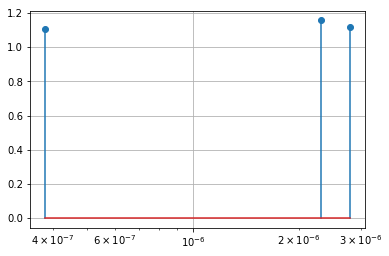

In [12]:
import matplotlib.pyplot as plt
plt.stem(params[:,0],loss[:],)
# plt.colorbar()
# plt.yscale('log')
plt.xscale('log',nonposx='clip',nonposy='clip')
plt.grid()
plt.show()

In [ ]:
params